# Sampled power analysis

In [1]:
import scanpy as sc
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import itertools
import warnings

import os
import pickle as pkl
%matplotlib inline
import imp

/tmp/ipykernel_3669474/3767633645.py:13: DeprecationWarning: the imp module is deprecated in favour of importlib and slated for removal in Python 3.12; see the module's documentation for alternative uses
  import imp


In [4]:
import sys
sys.path.append('/home/ubuntu/Github/scrna-parameter-estimation')
sys.path.append('/home/ssm-user/Github/misc-seq/miscseq/')
# import encode
import memento
# import run_memento

In [9]:
data_path  = '/Data/lupus/'
num_inds = [50, 60, 70, 80]
num_resample=10
cts = ['B', 'T8', 'T4', 'NK', 'cM', 'ncM']

In [10]:
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", ['turquoise', 'silver', 'slategrey'])


import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

### Sample the SNP and covariate dataframes

In [11]:
def drop_zero_col(df):
    
    return df.loc[:, (df != 0).any(axis=0)].copy()

### Plot the power figure

In [12]:
# Read the OneK result
onek_replication = pd.read_csv(data_path + 'filtered_onek_eqtls.csv')

In [13]:
cts = onek_replication.cg_cov.drop_duplicates().tolist()

In [14]:
onek_replication.shape

(9382, 10)

In [36]:
result_df = []
for pop in ['asian']:
    for num_ind in num_inds:
        for resample in range(num_resample):
            for ct in cts:
                meq = pd.read_csv(data_path + 'mateqtl_output/sampled/{}_{}_{}_{}.out'.format(pop, ct, num_ind, resample), sep='\t')
                mem = pd.read_csv(data_path + 'memento_1k/{}_{}_{}_{}.csv'.format(pop, ct, num_ind, resample))
                merged = mem.rename(columns={'tx':'SNP'}).merge(meq, on=['SNP', 'gene'], how='left')
                result_df.append((pop, num_ind, resample, ct, 'memento', mem.query('de_pval < 0.05').shape[0]/mem.shape[0]))
                result_df.append((pop, num_ind, resample, ct, 'pseudobulk', merged[merged['p-value']<0.05].shape[0]/merged.shape[0]))
result_df = pd.DataFrame(result_df, columns=['pop', 'num_ind', 'resample', 'ct', 'method', 'power'])

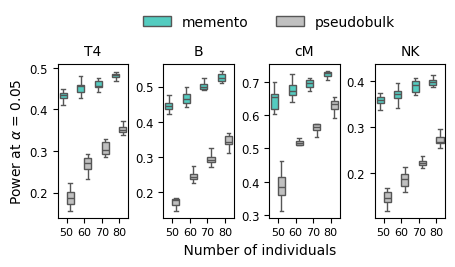

In [37]:
plt.figure(figsize=(5,2));
plt.subplots_adjust(wspace=0.5)
for idx, ct in enumerate(['T4', 'B', 'cM', 'NK']):
    plt.subplot(1, 4, idx+1);
#     sns.stripplot(x='num_ind', y='power', hue='method', data=result_df.query('ct == "B"'), dodge=True, palette='Set2', linewidth=1)
    sns.boxplot(x='num_ind', y='power', hue='method', data=result_df.query('ct == "{}"'.format(ct)), linewidth=1, fliersize=0)
#     plt.ylim(0.1, 0.75)
    if idx > 0:
#         plt.yticks([])
        plt.ylabel(None)
    else:
        plt.ylabel(r'Power at $\alpha$ = 0.05')
    if idx == 2:
        plt.legend(ncol=2, loc='upper center', bbox_to_anchor=(0,1.4), frameon=False)
    else:
        plt.legend([],[], frameon=False)
    plt.title(ct)
    plt.xticks(fontsize=8)
    if idx == 1:
        plt.xlabel('                            Number of individuals')
    else:
        plt.xlabel(None)
# plt.savefig('sampled_power.pdf', bbox_inches='tight')